## Data

In [148]:
# Imports and current/future - libraries/methodologies used

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf 
from pandas_datareader import data
from sklearn.preprocessing import MinMaxScaler

In [149]:
# Importing data 

df = pd.read_csv(os.path.join('Stocks','ibm.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])

In [150]:
# Data Exploration 

df = df.sort_values('Date')

df.info()
print('_____________________________________')
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14059 entries, 0 to 14058
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    14059 non-null  object 
 1   Open    14059 non-null  float64
 2   High    14059 non-null  float64
 3   Low     14059 non-null  float64
 4   Close   14059 non-null  float64
dtypes: float64(4), object(1)
memory usage: 659.0+ KB
_____________________________________


,Date,Open,High,Low,Close
0,1962-01-02,6.4130,6.4130,6.3378,6.3378
1,1962-01-03,6.3378,6.3963,6.3378,6.3963
2,1962-01-04,6.3963,6.3963,6.3295,6.3295
3,1962-01-05,6.3211,6.3211,6.1958,6.2041
4,1962-01-08,6.2041,6.2041,6.0373,6.0870


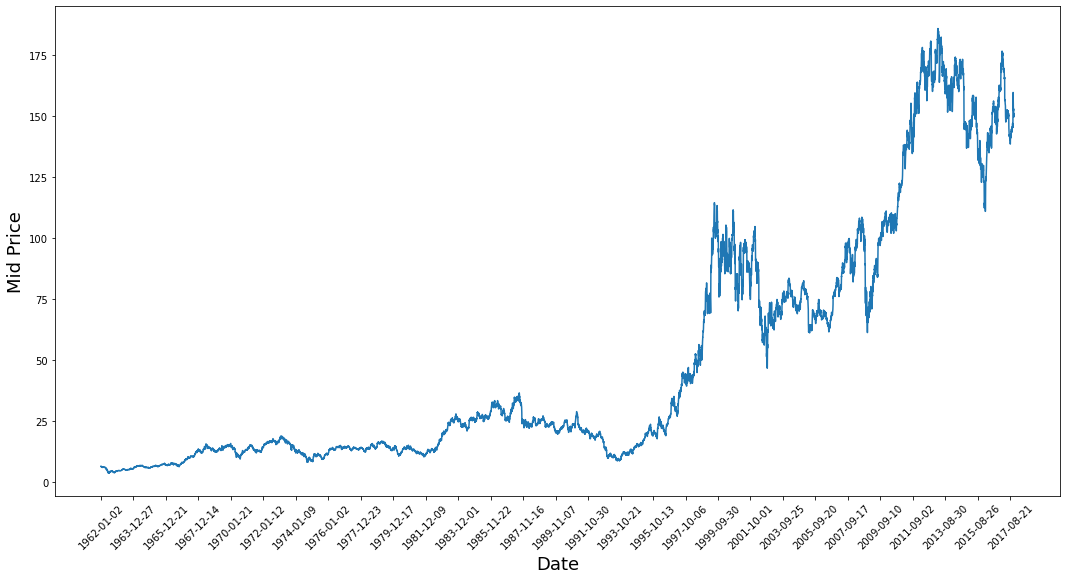

In [151]:
# Data Visualization

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)

plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)

plt.show()

## Preprocessing

In [152]:
# Calculating the mid prices from highest to lowest

high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [153]:
df.shape

(14059, 5)

In [160]:
# Splitting Training and Test Data

train_data = mid_prices[:14000]
test_data = mid_prices[14000:]
scaler = MinMaxScaler()

# Normalizing the data
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Train the Scaler with training data and smooth data
smoothing_window_size = 100
for di in range(0,3000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize TEST data
test_data = scaler.transform(test_data).reshape(-1)

MSE error for standard averaging: 13.86338


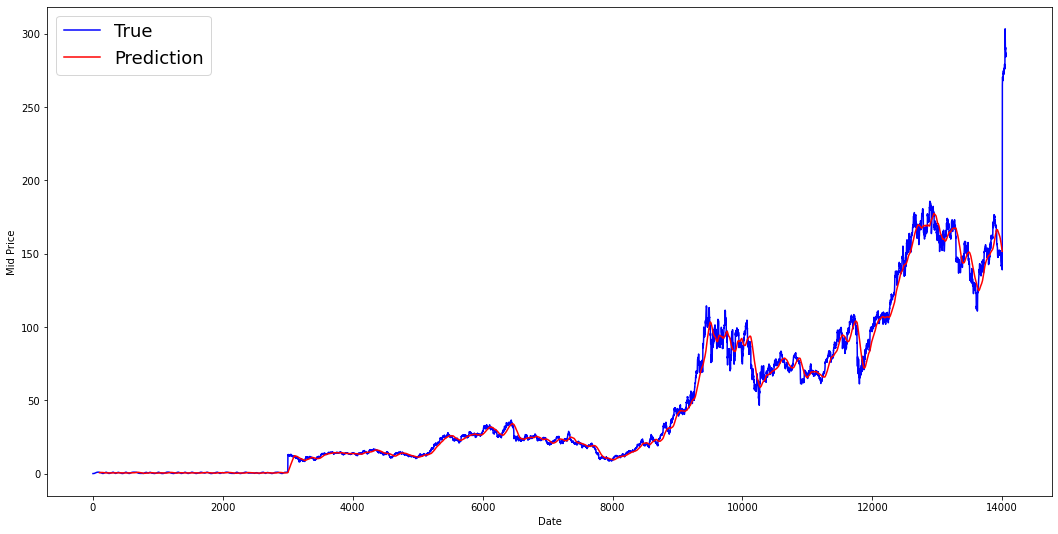

In [161]:
# Performing exponential moving average smoothing, so the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(3000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='r',label='Prediction')

plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

## LSTMs etc.